Name: Shiska Raut <br>
ID: 1001526329

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## Read training/evaluation data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: Each column in the array(s) epresents a single datapoint.

In [2]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    labels = []
    
    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')
            
            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)
            
            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        # convert labels list to array
        Y = np.array(labels, dtype = dtype_y, ndmin = 2)
        
        return X.transpose(), Y

## Read test data

**Argument(s):** 
1) name of a .txt file with each line containing test features(x) in the following format:
(x1, x2, .....xn) <br>
2) dtype_x: datatype of features

**Return(s):** 'X' where X is a numpy array of feature vectors.
Note: Each column in the array(s) epresents a single datapoint.

In [3]:
def get_X_array(filename, dtype_x):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    
    with f:
        line = f.readline()
        while line != '':
            
            # get feature values
            line = line.strip('\n')
            line = line.strip('( )')
            feat = line.split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        return X.transpose()

# 3) Softmax Regression

### Helper Functions

#### one_hot_encoder(arr) : return encoded_arr, label_idx_dict
**arr:** <br>
[['Ceramic' 'Metal' 'Metal' 'Metal' 'Ceramic' 'Plastic' 'Plastic'
  'Plastic' 'Plastic' 'Plastic' 'Plastic' 'Ceramic']]<br>  
**encoded_arr:** <br>
[[0 1 1 1 0 0 0 0 0 0 0 0]<br>
 [0 0 0 0 0 1 1 1 1 1 1 0]<br>
 [1 0 0 0 1 0 0 0 0 0 0 1]] <br>
**label_idx_dict:** <br>
{'Metal': 0, 'Plastic': 1, 'Ceramic': 2}

In [5]:
# given an array of attribute values for a categocial attribute,
# preforms one-hot-encoding and returns resulting binary array
def one_hot_encoder(arr):
    
    __, n_samples = arr.shape
    
    # get unique labels
    uniq_labels = set(arr[0,:].tolist())
    
    # get number of total attribute values
    n_labels = len(uniq_labels)
    
    # create an array of size n_labels*n_samples to store encoded values
    encoded_arr = np.zeros((n_labels, n_samples), dtype = int)
    
    # create dictionary to store row indev of each attribute value
    label_idx_dict = {}
    for i, v in enumerate(uniq_labels):
        label_idx_dict[v] = i
        
    # fill encoded_arr using attribute index dictionary and input arr
    for i in range(n_samples):
        # get index to encode as 1
        idx = label_idx_dict[arr[0,i]]
        encoded_arr[idx, i] = 1
        
    return encoded_arr, label_idx_dict


# adds bias as the first row to a dataset
def add_bias(X):
    
    n_feat, n_samples = X.shape
    X_b = np.ones((n_feat+1, n_samples), dtype = float)
    X_b[1::,:] = X
    
    return X_b


# plots a line graph 
def plot_change(X, title, xlab, ylab):
    
    fig = plt.figure(figsize = (10, 6))
    plt.plot(X, color = 'red')
    
    # add title and labels
    plt.title(title, fontdict = {'fontsize': 15})
    plt.xlabel(xlab, fontdict = {'fontsize': 12})
    plt.ylabel(ylab, fontdict = {'fontsize': 12})
    plt.grid()

    
# compares two arrays and returns class accuracy
def get_class_acc(Y_pred, Y):
    
    # create a dict to store class accuracy
    class_acc = {}
    
    # get all unique classes
    classes = set(Y[0,:].tolist())
    
    # get number of samples
    n_samples = Y_pred.shape[1]
    
    # calculate total occurence and accurate predictions for each class
    for c in classes:
        
        total = 0
        acc_vals = 0
        
        for i in range(n_samples):
            if Y[:,i] == c:
                total = total + 1
                if Y[:,i] == Y_pred[:,i]:
                    acc_vals = acc_vals + 1
                
        class_acc[c] = acc_vals/total
        
    return class_acc


# compares two arrays and returns total accuracy
def get_acc(Y_pred, Y):
    
    n_samples = Y_pred.shape[1]
    
    # reutrn overall accuracy
    return (np.sum(Y == Y_pred))/n_samples


### 3 a) Functions for Training and Prediction

In [9]:
# given a vector of parobaility values, returns label with max probability for a single sample
def get_sample_prediction_label(sfmax_net, label_idx_dict):
    
    # get inverse of the dictionary
    inv_label_idx_dict = {v: k for k, v in label_idx_dict.items()}
    
    # return label with max probability value
    return inv_label_idx_dict[int(np.argmax(sfmax_net, axis = 0))]


# uses softmax function and parameter matrix to get probability values
# for multiclass classification
def get_sample_prediction_values(x_sample, model_params):
    
    # calculate linear net value
    net = np.dot(model_params, x_sample)
    
    # calculate exponential value for rach class
    exp_net = np.exp(net, dtype = float)
    
    # calculate softmax value for each class
    sfmax_net = exp_net/np.sum(exp_net, axis = 0, dtype = float)
    
    return sfmax_net


# gets predictions for an entire test dataset
def get_predictions(X_test, model_params, label_idx_dict):

    # initialize list to store predictions
    Y_pred = []

    # get number of test samples
    n_feat, n_samples = X_test.shape

    for i in range(n_samples):
    
        x_sample = X_test[:,i].reshape(n_feat, 1)
        y_pred_values = get_sample_prediction_values(X_test[:,i], model_params)
        y_pred_label = get_sample_prediction_label(y_pred_values, label_idx_dict)
        Y_pred.append(y_pred_label)

    # convert labels list to numpy array
    Y_pred = np.array(Y_pred, dtype = str, ndmin = 2)

    return Y_pred  


# training with batch gradient descent
def train_softmax_regressor_batch(X_train, Y_train, alpha, epochs):
    
    # get number of features and samples
    n_feat, n_samples = X_train.shape
    
    # get no of classes/labels
    n_class, __ = Y_train.shape

    # get paramater matrix
    model_params = np.random.uniform(-0.01, 0.01, size = (n_class, n_feat))

    # initialize list to store net change in parameter values
    epoch_change_model_params = []
    
    for i in range(epochs):

        # initialize gradient vector for each epoch
        gradient_mtx = np.zeros((n_class, n_feat), dtype = float)

        for j in range(n_samples):
            
            # pick a sample 
            x_sample = X_train[:,j].reshape(n_feat,1)
            y_sample = Y_train[:,j].reshape(n_class, 1)
            
            # get prediction value
            y_pred = get_sample_prediction_values(x_sample, model_params)

            # calculate gradient matrix
            sample_gradient = np.dot((y_sample - y_pred), x_sample.transpose())
            gradient_mtx = gradient_mtx + sample_gradient
            
        # adjust parameter values using batch gradient descent 
        updated_params = model_params + (alpha*gradient_mtx)
        
        # get the net change in parameters
        net_change = np.sum(np.abs(model_params - updated_params))
        epoch_change_model_params.append(net_change)
            
        # set updated parameters as new parameters  
        model_params = updated_params.copy()
        
    # return final parameter matrix
    return model_params, epoch_change_model_params


# training with stochastic gradient descent
def train_softmax_regressor_stochastic(X_train, Y_train, alpha, epochs):
    
    # get number of features and samples
    n_feat, n_samples = X_train.shape
    
    # get no of classes/labels
    n_class, __ = Y_train.shape

    # get paramater matrix
    model_params = np.random.uniform(0, 0.01, size = (n_class, n_feat))
    model_params_init = model_params.copy()

    # initialize list to store net change in parameter values
    epoch_change_model_params = []
    
    for i in range(epochs):

        for j in range(n_samples):
            
            # pick a sample randomly
            idx = np.random.randint(0, n_samples)
            x_sample = X_train[:,idx].reshape(n_feat,1)
            y_sample = Y_train[:,idx].reshape(n_class, 1)
            
            # get prediction value
            y_pred = get_sample_prediction_values(x_sample, model_params)

            # calculate gradient matrix
            sample_gradient = np.dot((y_sample - y_pred), x_sample.transpose())
            
            # adjust parameter values using stochastic gradient descent 
            model_params = model_params + (alpha*sample_gradient)

        # get the net change in parameters
        net_change = np.sum(np.abs(model_params_init - model_params))
        epoch_change_model_params.append(net_change)

        # set updated parameters as new parameters  
        model_params_init = model_params.copy()
        
    # return final parameter matrix
    return model_params, epoch_change_model_params

### Provide Custom Filenames:
1) Training/evaluation file: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y)

2) Test file: name of a .txt file with each line containing test features(x) in the following format:
(x1, x2, .....xn)

In [6]:
fname_train = str(input('Enter file containing training data: '))
fname_test = str(input('Enter file containing test data: '))

X_train, Y_train = get_X_Y_arrays(fname_train, float, str)
X_test = get_X_array(fname_test, float)

Enter file containing training data: 3_train.txt
Enter file containing test data: 3_test.txt


### Plot class distribution of training data provided in assignment

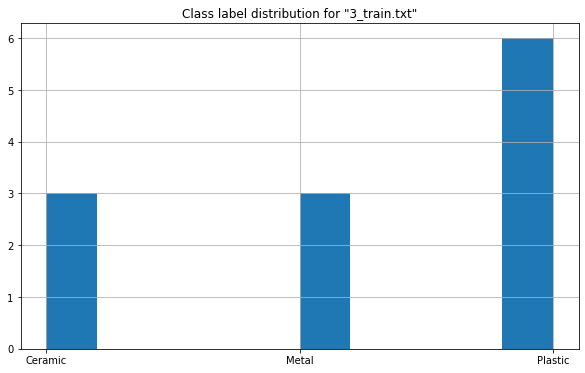

In [7]:
plt.figure(figsize = (10, 6))
plt.title(f'Class label distribution for "{fname_train}"')
plt.ylabel('No. of datapoints')
plt.hist(Y_train.squeeze())
plt.grid()

Training accuracy is 0.667.

Predictions for test data: 
 [['Plastic' 'Metal' 'Plastic' 'Plastic']]



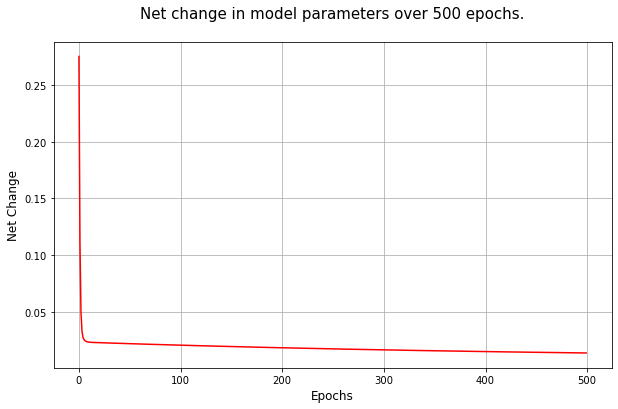

In [16]:
# set epochs and alpha
epochs = 500
alpha = 0.01

# add bias to X training and test data
X_train_b = add_bias(X_train)
X_test_b = add_bias(X_test)

# get encoded array for y
Y_train_encoded, label_idx_dict = one_hot_encoder(Y_train)

# train model and get predictions
model_params, epoch_change_model_params = train_softmax_regressor_batch(X_train_b, Y_train_encoded, alpha, epochs)
Y_train_pred = get_predictions(X_train_b, model_params, label_idx_dict)
Y_test_pred = get_predictions(X_test_b, model_params, label_idx_dict)

# get accuracy for training and test data
train_acc = get_acc(Y_train_pred, Y_train)
print(f'Training accuracy is {train_acc:.3f}.\n')
print(f'Predictions for test data: \n {Y_test_pred}\n')

#plot change net in parameter values
title = str( f'Net change in model parameters over {epochs} epochs.\n')
plot_change(epoch_change_model_params, title, 'Epochs', 'Net Change')

### 3 b) Function for leave-one-out evaluation

In [11]:
def leave_one_out_evaluation(X_eval, Y_eval, alpha, epochs, training_type):
    
    # add bias to X
    X_train_b = add_bias(X_eval)

    # get number of features and samples
    n_feat, n_samples = X_train_b.shape

    # prediction labels generated by 'predict_class_with_knn' will be stored in this list
    Y_pred = []

    # get encoded array for y
    Y_train_encoded, label_idx_dict = one_hot_encoder(Y_eval)
    n_class, __ = Y_train_encoded.shape
    
    # trains a new model to predict each sample
    for i in range(n_samples):
        
        # pick test datapoint
        x_test = X_train_b[:,i].reshape(n_feat, 1)
        y_test = Y_train_encoded[:,i].reshape(n_class, 1)
        
        # create traiing set by deleting test datapoint
        X_train = np.delete(X_train_b, i, axis = 1)
        Y_train = np.delete(Y_train_encoded, i, axis = 1)
        
        if training_type == 'batch':
            # train model
            model_params, epoch_change_model_params = train_softmax_regressor_batch(X_train, Y_train, alpha, epochs)
        else:
            # train model
            model_params, epoch_change_model_params = train_softmax_regressor_stochastic(X_train, Y_train, alpha, epochs)
        
        # get test data prediction
        y_pred_values = get_sample_prediction_values(x_test, model_params)
        y_pred_label = get_sample_prediction_label(y_pred_values, label_idx_dict)
        Y_pred.append(y_pred_label)
    
    # convert prediction list to numpy array
    Y_pred = np.array(Y_pred, dtype = str, ndmin = 2)
    acc = get_acc(Y_pred, Y_eval)
    
    # return predictions and accuracy
    return Y_pred, acc, epoch_change_model_params


### Provide evaluation file name
fname_eval: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>

In [12]:
fname_eval = str(input('Enter file containing training data: '))

Enter file containing training data: 3_eval.txt


In [13]:
# get data as arrays
X_eval, Y_eval = get_X_Y_arrays(fname_eval, float, str)
n_eval_samples = X_eval.shape[1]

### Plot class distribution of evaluation data

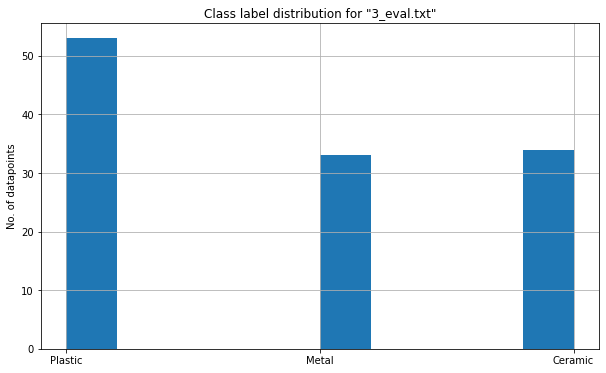

In [15]:
plt.figure(figsize = (10, 6))
plt.title(f'Class label distribution for "{fname_eval}"')
plt.ylabel('No. of datapoints')
plt.hist(Y_eval.squeeze())
plt.grid()

In [17]:
# set epochs and alpha
epochs = 2000
alpha = 0.001

# get predictions, test accuracy and change in model parameters over epochs for final evaluation datapoint
Y_eval_pred, test_acc, epoch_change_model_params = leave_one_out_evaluation(X_eval, Y_eval, alpha, epochs, 'batch')

### Get accuracy values

In [19]:
print(f"Test total accuracy for leave-one-out evaluation is {test_acc:.3f}.\n")

class_acc = get_class_acc(Y_eval_pred, Y_eval)
print('Class Accuracy')
for k, v in class_acc.items():
    print(f'{k} : {v:.4f}')

Test total accuracy for leave-one-out evaluation is 0.533.

Class Accuracy
Ceramic : 0.0588
Plastic : 0.9057
Metal : 0.4242


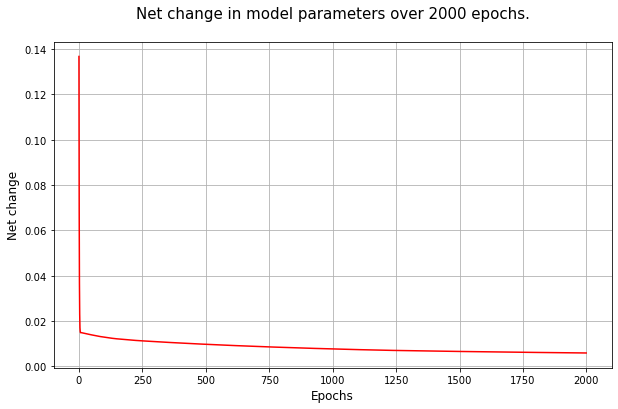

In [20]:
title = str(f'Net change in model parameters over {epochs} epochs.\n')
plot_change(epoch_change_model_params, title, 'Epochs', 'Net change')

### 3 b) Conclusion:

KNN best accuracy : ~0.517 (k = 3)<br>
Softmax Regression accuracy: ~0.533 (epochs = 2000 & alpha = 0.001)<br>

For the same classification problem, the best accuracy value for KNN was 0.517 with manhattan distance as a distance measure, and with k = 5. In case of logistic regression, the overall test accuracy is 0.533 after training the model for 2000 epochs (alpha = 0.001) with batch gradient descent. Upon analyzing the class accuracy, class 'Plastic' was found to have the highest accuracy with a value of ~0.90. This could be the result of the uneven class distribution in the training data. As the majority of training samples belonged to class "Plastic", the model learned that labeling datapoints as "Plastic" results in maximum probability.<br>

Softmax regression slighly outperforms KNN in this case and might perform better than KNN if uncorrelated attributes are present and the classes can be separated using a linear hyperplane. This is because softmax uses a parametric representation and can assign a low parameter value(like 0) to an uncorrelated feature through weight adjustments.

## 3 c) Evaluation after removing 4th attribute 

In [21]:
# remove fourth attribute
X_eval_3 = np.delete(X_eval, 3, axis = 0)

In [22]:
# set epochs and alpha
epochs = 2000
alpha = 0.001

# get predictions, test accuracy and change in model parameters over epochs for final evaluation datapoint
Y_eval_pred_3, test_acc_3, epoch_change_model_params_3 = leave_one_out_evaluation(X_eval_3, Y_eval, alpha, epochs, 'batch')

### Get accuracy values

In [23]:
print(f"Test total accuracy for leave-one-out evaluation after removing 4th attribute is {test_acc_3:.3f}.\n")

class_acc_3 = get_class_acc(Y_eval_pred_3, Y_eval)
print('Class Accuracy\n')
for k, v in class_acc_3.items():
    print(f'{k} : {v:.3f}')

Test total accuracy for leave-one-out evaluation after removing 4th attribute is 0.517.

Class Accuracy

Ceramic : 0.029
Plastic : 0.887
Metal : 0.424


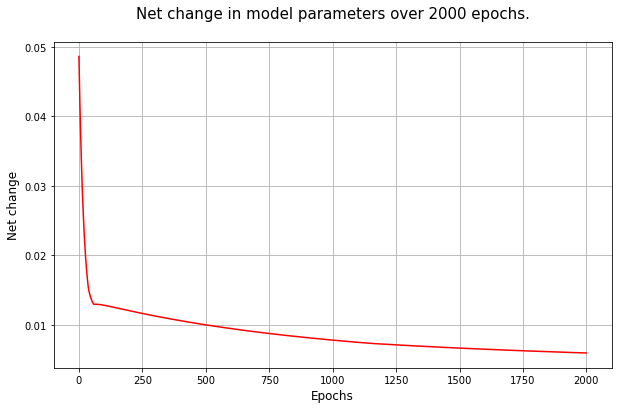

In [24]:
title = str(f'Net change in model parameters over {epochs} epochs.\n')
plot_change(epoch_change_model_params_3, title, 'Epochs', 'Net change')

### 3 c) Conclusion after removing 4th attribute:

KNN best accuracy: ~0.833 (k = 3)<br>
Softmax regression accuracy: ~0.517 (epochs = 2000 & alpha = 0.001)<br>

Removing the 4th attribute in KNN had resulted in an increase in accuracy from 0.517 to 0.833 for k = 3 which suggested that the 4th attribute(hue) could have been hightly uncorrelated. As KNN uses a non-paramteric representation, using a highly uncorrelated feature without normalizaton resulted in a low accuracy value. However, since softmax regression uses a parametric representation, it can learn to give a low weight to an uncorrelated feature. This explains why accuracy did not change much for logistic regression even after removing the 4th attribute.<br>

The fact that KNN greatly outperfomed softmax regression after the 4th attribute was removed could mean that the datasets in the feature space could not be effectively separated using a linear hyperplane. Therefore, KNN might perform better than softmax regression for datasets that can not be searated using a linear hyperplane as long as all uncorrelated features have been removed or normalized.